In [ ]:
%load_ext autoreload

# Examples of using GRLP

GRLP is a model that solves for the long-profile evolution of a fluvial channel using a built-in semi-implicit solver. 
In particular, it simulates the evolution of a gravel-bed river that shapes its bed by eroding, transporting, and depositing sediments. 
The model takes a few basic inputs, and since the numerical solver has been set up implicitly, the model can take long timesteps while remaining stable. 
As its basic inputs, the model takes a sediment and water input, a spatial domain, an uplift or subsidence rate (or equivalently, other local source or sink of material), and a floodplain width, plus a slew of appropriate constants. 
The model can also replace some of these with a set of power-law scaling relationships between downstream distance and (1) valley width, (2) drainage area, and (3) discharge.
If this approach is taken, it allows an analytical solution, assuming that these variables *actually* follow a power-law downstream. 
However, for the numerical solution, these can be an arbitrary functions up and downstream, instead of power laws. 

[Wickert & Schildgen (2019, ESurf)](https://esurf.copernicus.org/articles/7/17/2019/) describe the theory behind this model and the equations that are implemented numerically here.

First, we will present an example where we compare the numerical solution with power-law functions for important variables to the corresponding analytical solution, which will demonstrate some basic outcomes and methods of interacting with the model. 
The very first thing to do is load the relevant libraries.

In [2]:
# Import numerical and plotting libraries
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

# Import the GRLP module
import grlp

In [3]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GRLP is an object-oriented model, so next, we instantiate `grlp` model object,('`lp`') which creates the data structure, and associates methods with `lp`.

In [4]:
lp = grlp.LongProfile()

To provide `lp` with the necessary starting values, we set some constants and create the domain, using some handy built-in methods that set a suite of reasonable constants for Earth rivers.

In [5]:
# Set up the x domain
lp.set_x(dx=1000, nx=90, x0=10000)

# S0 is the upstream-end slope that determines the sediment input to the catchment
S0 = 1.5E-2

# Set up a starting set of channel-bed elevations (z) on a uniform slope (S0)
lp.set_z(S0=-S0, z1=0)

# Intermittency: What fraction of the total time is the river experiencing a
# geomorphically-effective flood? This assumes a binary on--off state, common 
# for gravel-bed rivers with floodplains (see Blom et al., 2017:
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JF004213).
# For an evaluation of the intermittency in general and its variability across
# a range of fluvial systems, see Hayden et al. (2021):
# https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2021GL092598
lp.set_intermittency(0.80)

# Set up the number of iterations in semi-implicit solver; 3 is a good default.
lp.set_niter(3)

# Utility functions to assign reasonable constants 
# (defined by Wickert & Schildgen, 2019)
lp.basic_constants()
lp.bedload_lumped_constants()
lp.set_hydrologic_constants()

As noted in the comments, the "intermittency" is a factor that simplifies a river channel's behavior into times of "shaping its channel" and times of performing no morphological work.
* For a discussion of the intermittency and its appropriateness as an approximation to the full hydrograph for the purposes of fluvial geomorphology, see [Blom et al., 2017, GRL](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017JF004213)
* For a catalog of intermittency values across a wide range of fluvial systems and a broader discussion of its significance, see [Hayden et al., 2021, JGR - Earth Surface](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2021GL092598) 

Pursuant to our assumption that valley width, discharge, and drainage area vary as power-law functions downstream, we will use handy setting functions that provide these values for the whole `x` domain.
* Distance downstream is known to scale with drainage area through Hack's Law (countless publications)
* The drainage-area--discharge relationship is well established, see:
    * 50 streams in PA and NJ, USA: [Aron and Miller, 1978](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1752-1688.1978.tb02169.x)
    * All USGS gages, including PR: [O'Connor and Costa, 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003WR002247)
    * Theoretical approach: [Sólyom and Tucker, 2004](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2003JF000032)
* The valley width -- drainage-area scaling is described in detail by [Langston & Temme (2019, GRL)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL085164), and they note a common exponent of *~0.4* in the power-law relation. Other relevant references include:
    * [Tomkin et al. (2003)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2001JB000862): exponent 0.76
    * [May et al. (2013)](https://pubs.geoscienceworld.org/gsa/geology/article/41/4/503/131211/Controls-on-valley-width-in-mountainous-landscapes): exponent 0.574
    * [Schanz & Montgomery (2016)](https://www-sciencedirect-com.ezp3.lib.umn.edu/science/article/pii/S0169555X16300150): exponents 0.22, 0.34

In [6]:
# Set up transfer functions between drainage area (A), discharge (Q), and
# valley width (B).

# drainage area: A = k_xA * x**P_xA
lp.set_A(k_xA=1., P_xA = 7/4)

# discharge: Q = k_xQ * x**P_xQ
lp.set_Q(k_xQ = 1.43e-5, P_xQ = 7/4*0.7)

# Valley width: B = k_xB * x**P_xB
lp.set_B(k_xB = 4, P_xB = 0.4)

# Set the uplift rate [m/s]; positive upwards
lp.set_uplift_rate(0)

# Set the base level 
# This is currently redundant, but will be useful later. 
# the set_z function already assumes that z_bl starts at 0.
lp.set_z_bl(0.)

For the last part, we will set the input sediment discharge, which arrives in the upstream (in our case left-most) model node. 

In [7]:
# Input sediment discharge: this is set based on your defined S0, above.
# (this ficticious boundary-condition slope is the transport slope for the
#  amount of sediment being supplied)

Qs0 = lp.k_Qs * lp.Q[0] * (S0)**(7/6.)

lp.set_Qs_input_upstream(Qs0)

Let's see what the initial model domain looks like, just making a plot of the long-profile. You'll notice that it's just a flat line, because of `lp.set_z(S0=-S0, z1 = 0)` above.

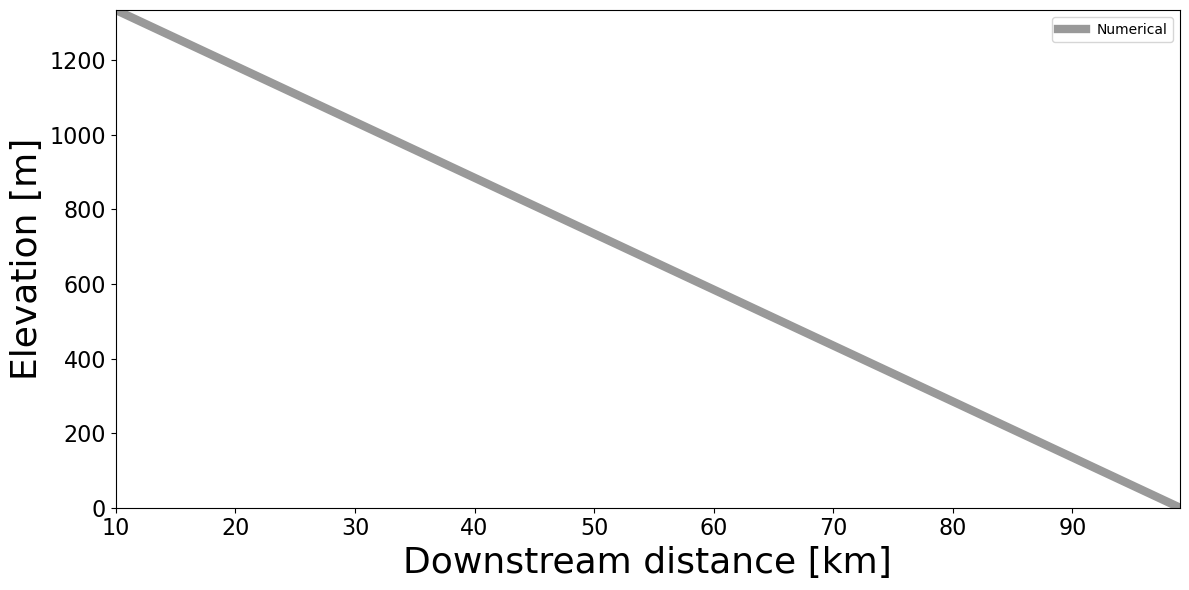

In [8]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(lp.x/1000., lp.z, '0.6', linewidth=6, label='Numerical')
plt.xlim(lp.x.min()/1000, lp.x.max()/1000)
plt.ylim(0, lp.z.max())
plt.xlabel('Downstream distance [km]', fontsize=26)
plt.ylabel('Elevation [m]', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.tight_layout()
plt.show()

Now, we can evolve the river profile, and calculate the analytical and numerical solutions.

In [9]:
# Numerical: (number of time steps, length of time step [s])
# note that this is a very long time step (31 Ma)
lp.evolve_threshold_width_river(1, 1E15)
# Analytical, no time steps, just solve for equilibrium profile.
zanalytical = lp.analytical_threshold_width() # suppress printing returned data.

We can now plot the analytical solution, and the numerical solution together. They match!

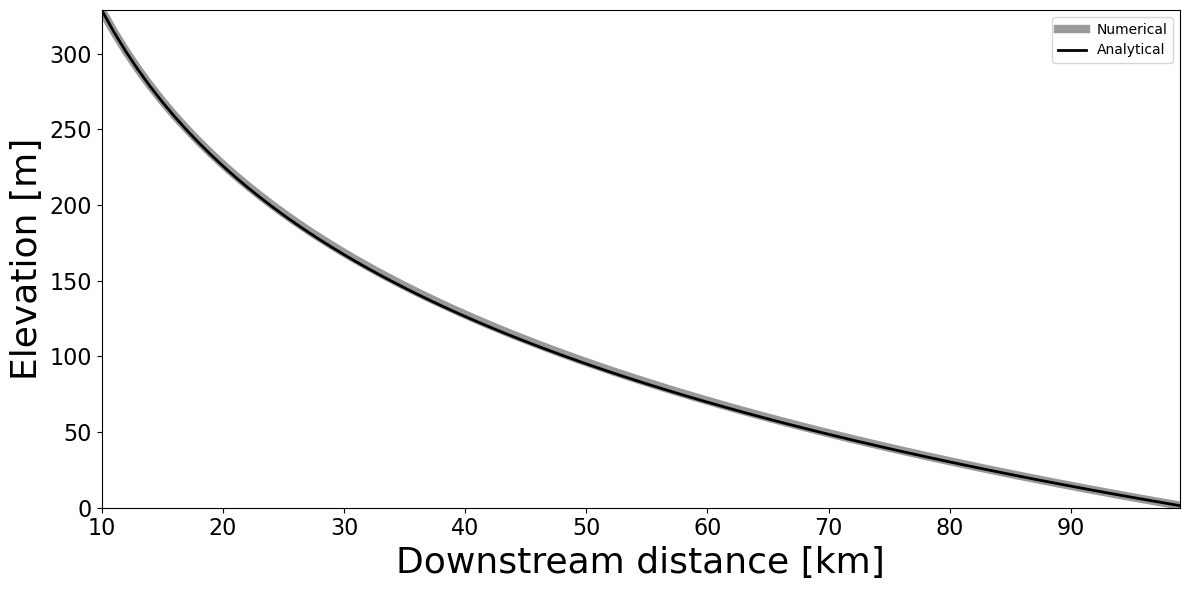

In [10]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(lp.x/1000., lp.z, '0.6', linewidth=6, label='Numerical')
plt.plot(lp.x/1000., lp.zanalytical, 'k', linewidth=2, label='Analytical')
plt.xlim(lp.x.min()/1000, lp.x.max()/1000)
plt.ylim(0, lp.z.max())
plt.xlabel('Downstream distance [km]', fontsize=26)
plt.ylabel('Elevation [m]', fontsize=26)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend()
plt.tight_layout()
plt.show()

So what is the geometry of this channel? The model object `lp` has a lot of attributes and methods. You can query them (like any other python object), using `dir()`.

In [11]:
dir(lp)

['A',
 'A_ext',
 'B',
 'C0',
 'C1',
 'D',
 'ID',
 'L',
 'LHSmatrix',
 'P_AQ',
 'P_a',
 'P_xA',
 'P_xB',
 'P_xQ',
 'Q',
 'Q_s_0',
 'Qs_internal',
 'RHS',
 'S0',
 'U',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'analytical_threshold_width',
 'analytical_threshold_width_perturbation',
 'b',
 'basic_constants',
 'bcl',
 'bcr',
 'bedload_lumped_constants',
 'build_LHS_coeff_C0',
 'build_matrices',
 'c_a',
 'center',
 'compute_Q_s',
 'compute_Qs_gain',
 'compute_Qs_lag',
 'compute_Qs_series_terms',
 'compute_channel_width',
 'compute_coefficient_time_varying',
 'compute_diffusivity',
 'compute_e_folding_time',
 'compute_equilibration_time',
 'compute_fl

And we can see that the object has an attribute `B` for valley width, and `b` for river width. If we query `B`...

In [12]:
print(lp.B)

[159.24286822 165.43106491 171.29018947 176.86314045 182.18440794
 187.2821968  192.17990944 196.8972089  201.4507986  205.85500554
 210.12222435 214.26326041 218.28759884 222.20361786 226.01876004
 229.739671   233.37231295 236.9220583  240.3937675  243.79185421
 247.12034023 250.38290209 253.58291079 256.72346587 259.80742475
 262.8374282  265.81592238 268.74517822 271.62730829 274.4642817
 277.25793726 280.00999512 282.7220671  285.39566593 288.03221349
 290.63304818 293.19943157 295.73255438 298.23354186 300.70345866
 303.1433133  305.55406215 307.93661309 310.29182888 312.62053016
 314.9234983  317.20147792 319.45517922 321.68528021 323.89242863
 326.07724384 328.24031847 330.38222003 332.50349232 334.60465683
 336.68621393 338.7486441  340.79240894 342.81795224 344.82570089
 346.81606575 348.78944251 350.74621239 352.68674294 354.61138864
 356.52049159 358.41438207 360.29337908 362.15779093 364.00791565
 365.84404154 367.66644754 369.47540366 371.2711714  373.05400409
 374.824147

but if we query `b` we get...

In [13]:
print(lp.b)

None


because this information about channels (width, depth, etc.) is computed after the fact, and it requires knowledge of the grain size and sediment discharge everywhere, which either cancels out of our is calculated within the equations for long-profile evolution.
The `LongProfile` class contains methods to calculate these, but because we follow the near-threshold channel-geometry closure of [Parker (1978)](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/selfformed-straight-rivers-with-equilibrium-banks-and-mobile-bed-part-2-the-gravel-river/3AD9322C1939528ED73D409654E35E22) (Gravel on banks exactly at the threshold of motion at a bankfull, or equivalently in this framework, geomorphologically effective flow), computing the channel width and flow depth (= channel depth) also requires us to know the grain size.
Let's say that this input grain size is 10 cm.

In [14]:
lp.compute_Q_s()
lp.D = 0.1
lp.compute_channel_width()
lp.compute_flow_depth()
print(lp.b)

[0.67597848 0.69708331 0.69708287 0.69715253 0.69727457 0.69743678
 0.69763052 0.69784948 0.69808892 0.69834524 0.69861562 0.69889779
 0.69918995 0.69949058 0.69979844 0.70011246 0.70043173 0.70075546
 0.70108294 0.70141356 0.70174676 0.70208204 0.70241895 0.70275707
 0.70309601 0.70343542 0.70377495 0.7041143  0.70445318 0.7047913
 0.70512839 0.70546422 0.70579853 0.7061311  0.7064617  0.70679013
 0.70711618 0.70743965 0.70776036 0.70807811 0.70839273 0.70870404
 0.70901187 0.70931607 0.70961646 0.7099129  0.71020522 0.71049328
 0.71077694 0.71105604 0.71133046 0.71160004 0.71186467 0.71212419
 0.7123785  0.71262745 0.71287093 0.7131088  0.71334096 0.71356727
 0.71378763 0.71400192 0.71421001 0.71441181 0.7146072  0.71479608
 0.71497833 0.71515384 0.71532252 0.71548427 0.71563897 0.71578653
 0.71592685 0.71605984 0.71618539 0.7163034  0.7164138  0.71651647
 0.71661133 0.71669828 0.71677725 0.71684813 0.71691083 0.71696528
 0.71701138 0.71704904 0.71707819 0.71709873 0.71711059 0.71711

And we can plot these things too.

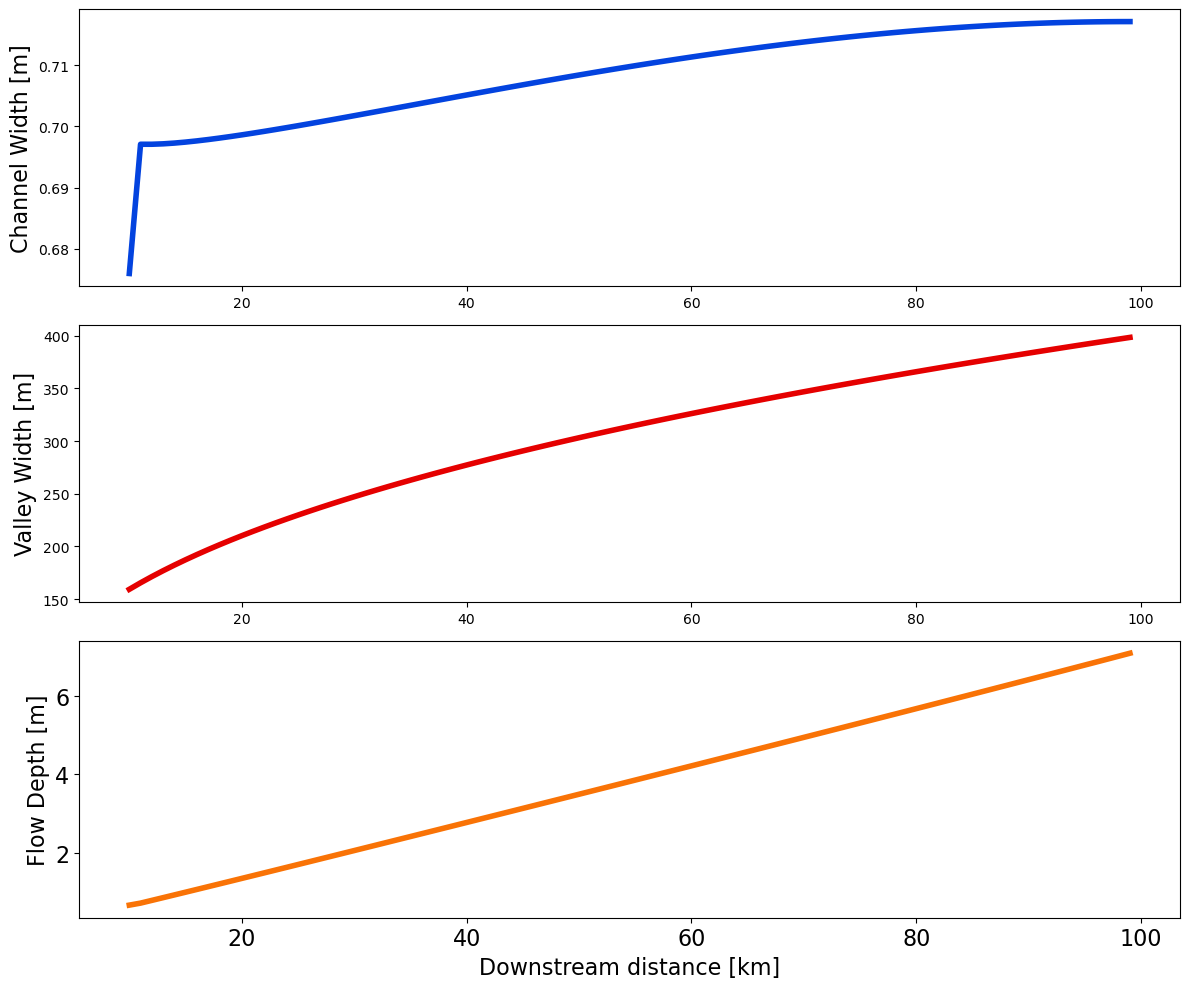

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.b, 'xkcd:blue', linewidth=4)
axes[1].plot(lp.x/1000., lp.B, 'xkcd:red', linewidth=4)
axes[2].plot(lp.x/1000., lp.h, 'xkcd:orange', linewidth=4)
axes[2].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_ylabel('Channel Width [m]', fontsize=16)
axes[1].set_ylabel('Valley Width [m]', fontsize=16)
axes[2].set_ylabel('Flow Depth [m]', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()


This is the basic usage of the model, which is for a given long-profile of a single stream, to calculate the equilibrium profile. 
Now, there are plenty of situations where the analytical profile would not be expected to match the numerical profile, because there are several simplifying assumptions applied to the analytical solution to render the math tractable.
1. Uplift is assumed to match river incision exactly for the analytical solution.
2. Discharge, Drainage Area, and Valley Width must be specified functions of downstream distance. However, the model does not specify _why_ that should be, only that it is. So if the downstream function of these variables is anything but a power law, the solutions should be different. 

So, for fun, let's violate #1 and see how it goes.
First, we will make a copy of the existing object using `deepcopy`, then we will change the boundary conditions, and run each of them forward. 

In [16]:
lp_uplift = deepcopy(lp)
lp_uplift.set_uplift_rate(1e-10) # in [m/s]

lp_uplift.evolve_threshold_width_river(1, 1E15) # evolve for the same amount of time as lp
_ = lp_uplift.analytical_threshold_width()

lp.evolve_threshold_width_river(1, 1E15) # this is unnecessary, but it's not expensive
_ = lp.analytical_threshold_width()

lp.compute_Q_s()
lp.compute_channel_width()
lp.compute_flow_depth()

lp_uplift.compute_Q_s()
lp_uplift.compute_channel_width()
lp_uplift.compute_flow_depth()

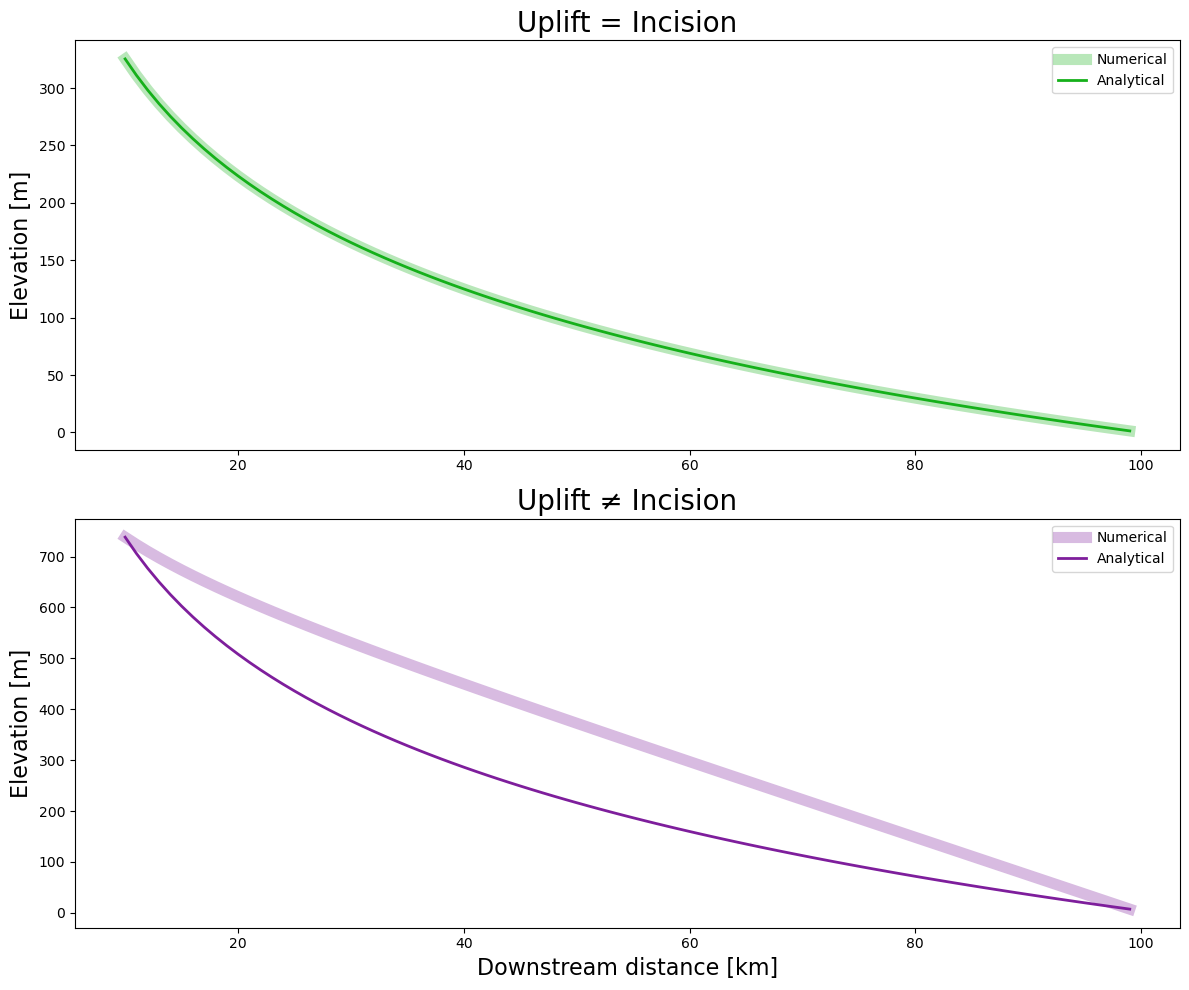

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.z, 'xkcd:green', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[0].plot(lp.x/1000., lp.zanalytical, 'xkcd:green', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].plot(lp.x/1000., lp_uplift.z, 'xkcd:purple', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[1].plot(lp.x/1000., lp_uplift.zanalytical, 'xkcd:purple', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_title('Uplift = Incision', fontsize = 20)
axes[1].set_title('Uplift ≠ Incision', fontsize = 20)
for a in axes:
    a.set_ylabel('Elevation [m]', fontsize=16)
    a.legend()
    a.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

Violating #2 does other interesting stuff.

In [18]:
# Screw with transfer functions between drainage area (A), discharge (Q), and valley width (B).
# Instead of power laws, these are now either constants, or a linear function 
# (drainage area has to increase downstream --- that's just geometry)

lp_constantQBA = deepcopy(lp)

lp_constantQBA.set_Q(Q = np.repeat(lp.Q[0], len(lp.x)))
lp_constantQBA.set_B(B = np.repeat(lp.B[0], len(lp.x)))
lp_constantQBA.set_A(A = lp.x * np.repeat(lp.A[0], len(lp.x)))

In [19]:
lp_constantQBA.evolve_threshold_width_river(1, 1E15) # evolve for the same amount of time as lp
_ = lp_constantQBA.analytical_threshold_width()

lp_constantQBA.compute_Q_s()
lp_constantQBA.compute_channel_width()
lp_constantQBA.compute_flow_depth()

lp.evolve_threshold_width_river(1, 1E15) # this is unnecessary, but it's not expensive
_ = lp.analytical_threshold_width()

lp.compute_Q_s()
lp.compute_channel_width()
lp.compute_flow_depth()

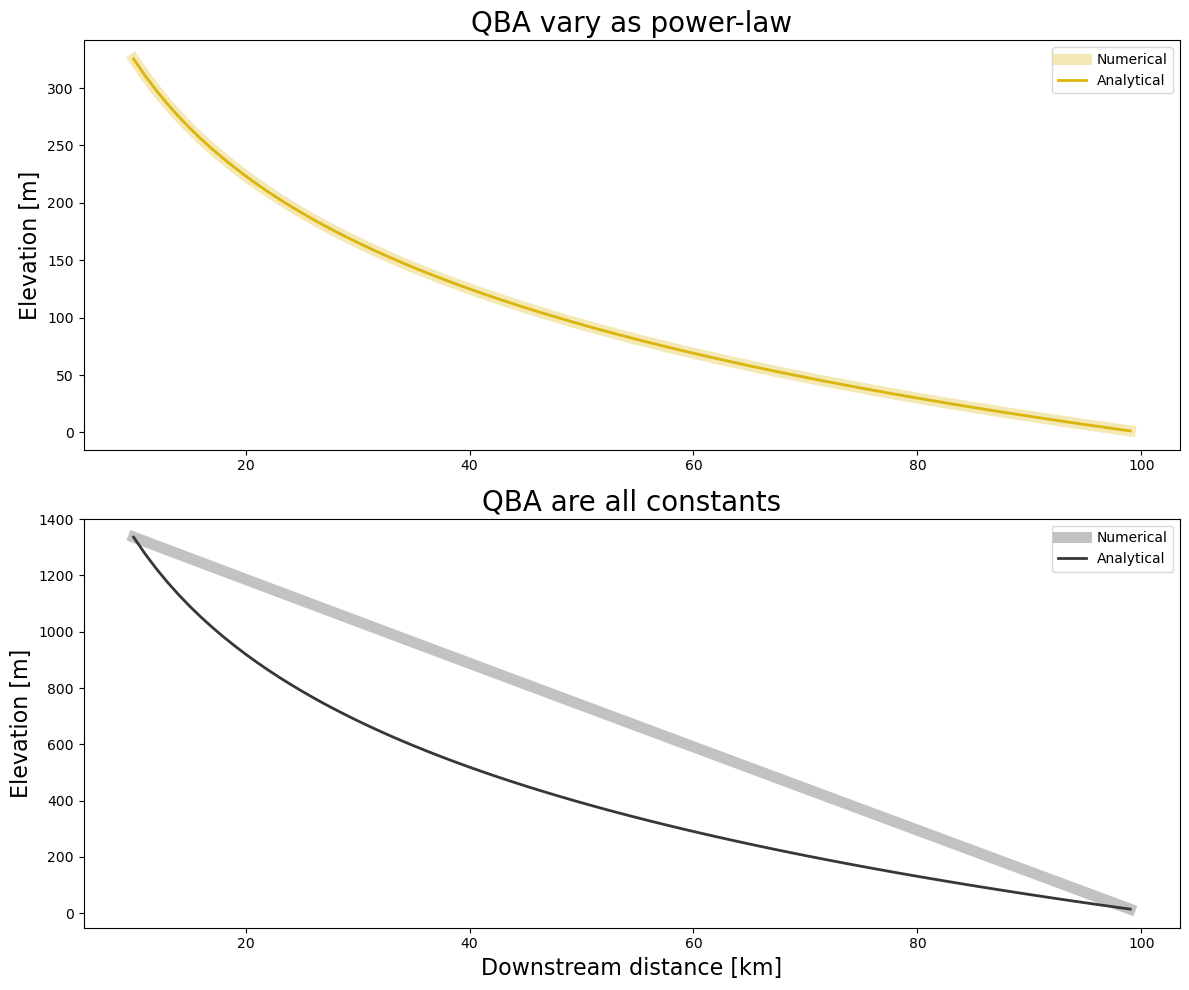

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].plot(lp.x/1000., lp.z, 'xkcd:gold', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[0].plot(lp.x/1000., lp.zanalytical, 'xkcd:gold', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].plot(lp.x/1000., lp_constantQBA.z, 'xkcd:dark grey', linewidth=8, label = 'Numerical', alpha = 0.3)
axes[1].plot(lp.x/1000., lp_constantQBA.zanalytical, 'xkcd:dark grey', linewidth=2, label = 'Analytical', alpha = 1)
axes[1].set_xlabel('Downstream distance [km]', fontsize=16)
axes[0].set_title('QBA vary as power-law', fontsize = 20)
axes[1].set_title('QBA are all constants', fontsize = 20)
for a in axes:
    a.set_ylabel('Elevation [m]', fontsize=16)
    a.legend()
    a.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()

The river can also evolve through time! Till now, this tutorial uses _really_ big timesteps (300 My), but the model can also resolve shorter time. Here's a quick example, where an sudden increase in uplift rate is applied to the upstream end of our original channel profile `lp`.

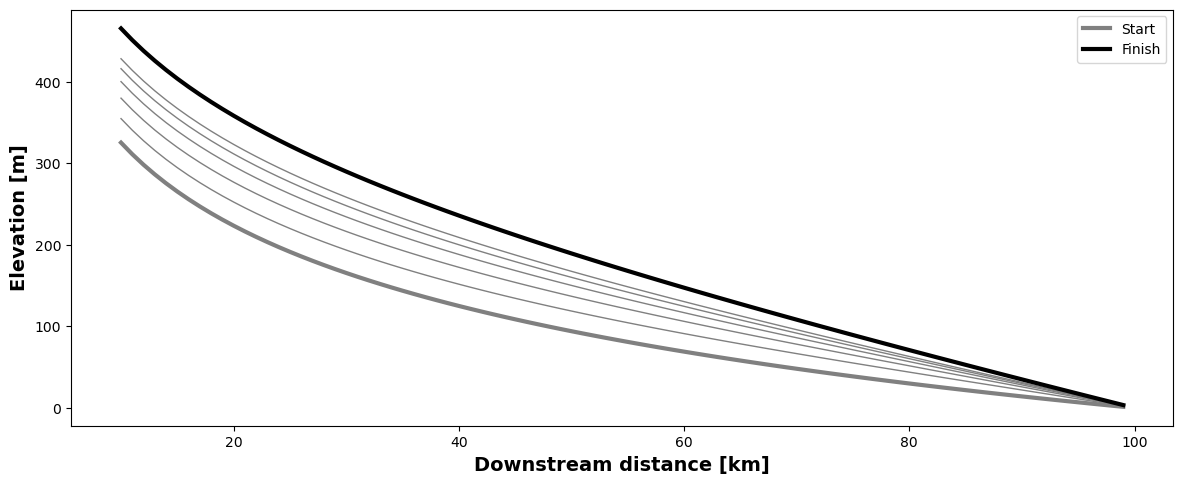

In [21]:
lp_increase = deepcopy(lp)
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,1,1)
plt.xlabel('Downstream distance [km]', fontsize=14, fontweight='bold')
plt.ylabel('Elevation [m]', fontsize=14, fontweight='bold')
plt.tight_layout()

# Initial condition
ax1.plot(lp.x/1000., lp_increase.z, color='.5', linewidth=3, label = 'Start')

# Transient
U = 1E-3
lp_increase.set_uplift_rate(U/3.15E7)
for i in range(5):
    lp_increase.evolve_threshold_width_river(1, 1E12) # five timesteps of 31 ka
    ax1.plot(lp_increase.x/1000., lp_increase.z, color='.5', linewidth=1)

# New equilibrium
lp_increase.evolve_threshold_width_river(1, 1E14) # final state 3 Ma later
ax1.plot(lp.x/1000., lp_increase.z, color='0', linewidth=3, label = 'Finish')

ax1.legend()
